# Read a sw_tint and do peakfinding on it.

[15-Apr-25 08:37:24] INFO: Loading mms1_edp_scpot_fast_l2...
[15-Apr-25 08:37:25] INFO: Loading mms1_dsp_epsd_omni...


NameError: name 'epsd_peakfinder' is not defined

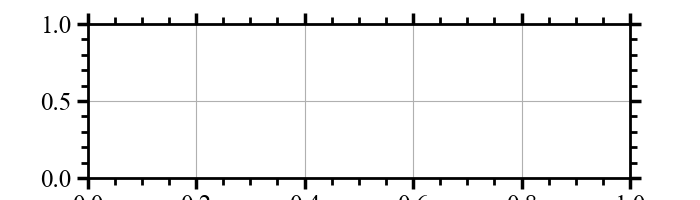

In [9]:
%matplotlib widget
%reload_ext autoreload
%autoreload 2
import numpy as np
from pyrfu.plot import plot_line, plot_spectr
from pyrfu import mms
import matplotlib.pyplot as plt


plt.style.use('../msc-project/figstyle.mplstyle')
from matplotlib.font_manager import fontManager
fontManager.addfont('../msc-project/fonts/TIMES.TTF')


h = np.genfromtxt('sw_tints/compiled_sw_tints.csv', dtype=str,delimiter=',', skip_header=1)
# j = h[np.random.randint(0, len(h))]
# tint = [str(j[0]), str(j[1])]
# ic = j[2]
ic = 1
# tint = ['2018-04-02T23:12:45.752031977', '2018-04-03T02:44:09.883192811']
# tint = ['2021-12-23T03:14:35.000000000', '2021-12-24T00:11:07.775909000'] # nice event
tint = ['2024-05-03T17:00:00.000000000', '2024-05-04T08:40:00.00'] # BENCHMARK
vsc = mms.get_data("v_edp_fast_l2", tint, 1)
epsd = mms.db_get_ts(f'mms{ic}_dsp_fast_l2_epsd',f'mms{ic}_dsp_epsd_omni', tint)

# Convert spectral power from (V/m)^{2}/Hz -> (mV/m)^{2}/Hz
epsd.data *= 1e6
epsd.attrs['UNITS'] = '(mV/m)^{2}/Hz'

plt.close('all')
fig, ax = plt.subplots(1, figsize=(7, 2))

epsd_cut, f_peaks, median_peak = epsd_peakfinder(epsd, 1e-4)
print(tint)
print(median_peak)
if f_peaks is None:
    print('No peaks found')

else:
    f_peaks_runmed = f_peaks.rolling(time=5, min_periods=5, center=True).median().dropna('time')
    ax_s, ax_c = plot_spectr(ax, epsd_cut, clim='auto', yscale='log', cscale='log', cmap='jet')
    plot_line(ax, f_peaks, linestyle='none', marker='.', color='black', markersize=3)
    plot_line(ax,f_peaks_runmed, linestyle='', marker='.', color='magenta',  markersize=1)
    ax.axhline(median_peak, 0, 1, linestyle='dashed')





In [ ]:
l = ['2024-05-03T17:00:00.000000000', '2024-05-04T08:40:00.00']
str(l)

"['2024-05-03T17:00:00.000000000', '2024-05-04T08:40:00.00']"

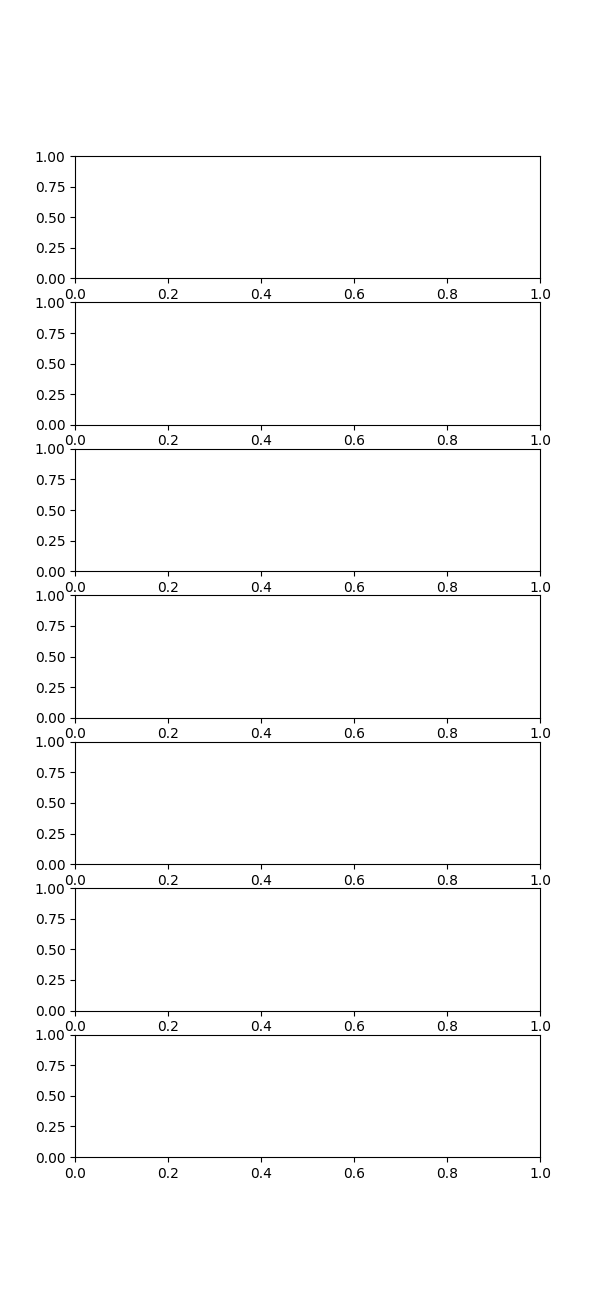

In [ ]:

def _weighted_median(values, weights):
    sorted_idx = np.argsort(values)
    values, weights = values[sorted_idx], weights[sorted_idx]
    cumsum = np.cumsum(weights)
    return values[np.searchsorted(cumsum, 0.5 * cumsum[-1])]

epsd_data = epsd

freq_axis = epsd_data.E_Freq.data
time_axis = epsd_data.time.data
peaks_f = np.full(time_axis.size, np.nan)


    
# Remove duplicates (Pyrfu bug when data is read across midnight)
if len(np.unique(epsd_data.time.data)) != len(epsd_data.time.data):
    epsd_data = epsd_data.drop_duplicates(dim='time')
    time_axis = epsd_data.time.data
    peaks_f = np.full(time_axis.size, np.nan)

freq_min, freq_max = [5.88800e3, 8e4]
fmin_idx = np.argmin(np.abs(freq_axis - freq_min))+1
fmax_idx = np.argmin(np.abs(freq_axis - freq_max))

epsd_cut = epsd_data - epsd_data.median(dim="time") # Subtract median to remove presistent noise
epsd_cut_f = epsd_cut[:, fmin_idx:fmax_idx] # Keep data in freq. range

pwrs = np.logspace(-6, 0, 7)

fig, axs = plt.subplots(nrows=len(pwrs), figsize=(6, 13))


# for i,pwr_thresh in enumerate(pwrs):
#     epsd_cut_f_p = epsd_cut_f.where(epsd_cut_f >= pwr_thresh, 0) # Only keep points with sufficient amplitude
#     ax = axs[i]
#     plot_spectr(ax, epsd_cut_f_p, clim='auto', yscale='log', cscale='log', cmap='jet')

#     for tidx in range(time_axis.size):
#         spectrum = epsd_cut_f_p[tidx, :].data
#         spectrum = np.where(spectrum > 0, spectrum, 0)  # Zero out negative values
        
#         peak_index = np.argmax(spectrum)
#         peak_f = freq_axis[fmin_idx + peak_index]
#         peaks_f[tidx] = peak_f
        
#     # Convert to time series
#     peaks_f_ts = pyrf.ts_scalar(time_axis, peaks_f)
#     peaks_f_ts = peaks_f_ts[~np.isnan(peaks_f)]
#     # Normalize weights to favor high frequencies
#     weights = (peaks_f_ts.data)**2 / np.max(peaks_f_ts.data) 
#     # weights = (peaks_f_ts.data / np.max(peaks_f_ts.data))**2
    
#     # weights = np.exp(peaks_f_ts.data / np.max(peaks_f_ts.data))
    
#     median_peak = _weighted_median(peaks_f_ts.data, weights)
#     # Only keep peaks within certain range of weighted median
#     peaks_f_ts_final = peaks_f_ts.where(abs(peaks_f_ts - median_peak) < 1*np.std(peaks_f_ts))
    
#     plot_line(ax, peaks_f_ts_final, color='magenta', linestyle='', marker='.')
#     ax.axhline(median_peak, 0, 1, color='black')
#     ax.text(0.5, 0.5, median_peak, transform=ax.transAxes)

[09-Apr-25 17:45:21] WARNING: /tmp/ipykernel_125702/1730740165.py:18: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(data.data / np.max(data.data))  # Spectral power



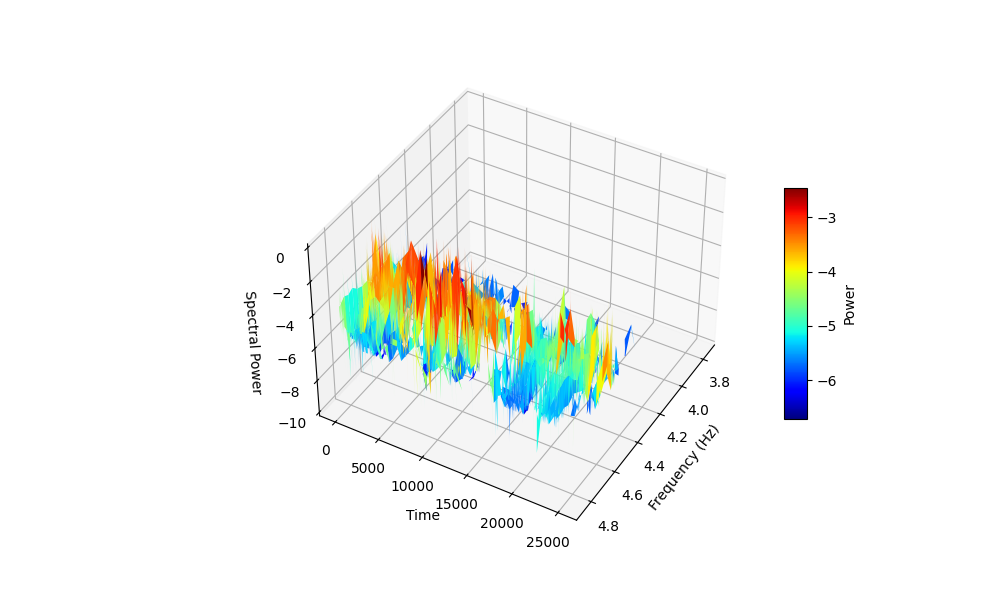

In [ ]:
# Inspect spectrum in 3D
# h = np.genfromtxt('sw_tints/compiled_sw_tints.csv', dtype=str,delimiter=',', skip_header=1)
# j = h[np.random.randint(0, len(h))]
# tint = [str(j[0]), str(j[1])]
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
# tint = ['2019-05-10T06:39:40.000000000', '2019-05-10T06:44:20.000000000']
# ic = 3
# epsd = mms.db_get_ts(f'mms{ic}_dsp_fast_l2_epsd',f'mms{ic}_dsp_epsd_omni', tint)
# Extract data from xarray.DataArray

data = epsd_cut
# data = epsd

time_numeric = (data.time - data.time[0]) / np.timedelta64(1, 's')

X, Y = np.meshgrid(np.log10(np.flip(data.E_Freq.data)), time_numeric)  # Frequency and time meshgrid
Z = np.log10(data.data / np.max(data.data))  # Spectral power



# Create figure and 3D axis
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=40, azim=30, roll=0)
# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='jet', edgecolor='none')

# Labels and colorbar
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Time')
ax.set_zlabel('Spectral Power')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Power')





plt.show()

# Feed peaks into SCpot calibration

[09-Apr-25 18:00:00] INFO: Loading mms1_edp_scpot_fast_l2...


[09-Apr-25 18:00:00] INFO: Using averages in resample


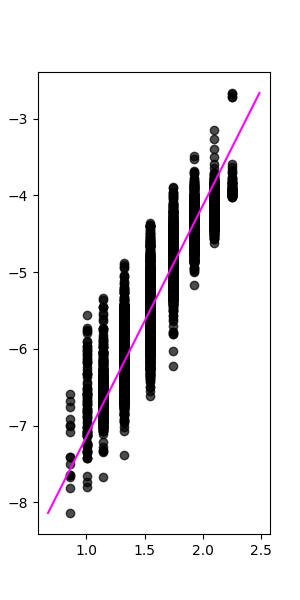

In [ ]:

import numpy as np
import xarray as xr
from scipy import optimize

from pyrfu import pyrf
from ne2fpe import ne2fpe

# Fitting formula from Khotyaintsev 2021 using RPW
def _vsc2ne_fit(vsc, ne):
    
    log_ne = np.log(ne)

    fit_results = np.polyfit(vsc, log_ne, deg=1, cov=True)
    b, a = fit_results[0]
    covar = fit_results[1]

    N0_fit = np.exp(a)
    beta_fit = -1/b
    # print(f'Fitted {len(ne), len(vsc)} ne peaks to spacecraft potential with', N0_fit, beta_fit)

    return N0_fit, beta_fit, covar


def fpeaks_scpot2ne(vsc_data, f_peaks, method=2, coeffs=None, outliers=False):
    # Convert fpe [Hz] --> ne [cm^-3]
    ne_peaks = ne2fpe(f_peaks, inverse=True)
    
    if vsc_data.size != ne_peaks.size:
        raise IndexError('Peaks and Vsc points are not 1-to-1')
    
    
    if method == 1:
        # Clean fit of both parameters with no fallback
        print('Method 1')

        
    elif method == 2:
        # Fit both paramters and use beta_fallback from <Vsc> if fit result "goes crazy"
        # print('Method 2')
        
        N0, beta, covar = _vsc2ne_fit(vsc_data, ne_peaks)
        outliers_idxs = np.zeros_like(ne_peaks, dtype=np.bool_)
        
        
    elif method == 3:
        # Only fit N0
        print('Method 3')
    
    if outliers:
        # Determine outliers
        ne_bestfit = N0 * np.exp(-vsc_data / beta) 
        residuals = ne_bestfit.data - ne_peaks.data
        std = (residuals - np.median(residuals)) / np.std(residuals)
        outliers_idxs = np.abs(std) > 3
        
        ne_peaks_valid = ne_peaks[~outliers_idxs]
        vsc_data_valid = vsc_data[~outliers_idxs]
        
        N0, beta, covar = _vsc2ne_fit(vsc_data_valid, ne_peaks_valid)
        
    

    return N0, beta, covar, outliers_idxs

vsc_ = mms.get_data('v_edp_fast_l2', tint, ic)
vsc = vsc_.drop_duplicates(dim='time')
vsc[abs(vsc) > 1e3] = None

f_peaks = f_peaks_runmed
vsc_rs = pyrf.resample(vsc, f_peaks.time, f_s=pyrf.calc_fs(f_peaks))

valid_idxs = np.isfinite(vsc_rs.data) & np.isfinite(f_peaks.data)
vsc_tofit = vsc_rs[valid_idxs]
f_peaks_tofit = f_peaks[valid_idxs]


N0, beta, covar, outliers_idxs = fpeaks_scpot2ne(vsc_tofit, f_peaks_tofit, outliers=True)
vsc_no_out = vsc_tofit[~outliers_idxs]
f_peaks_no_out = f_peaks_tofit[~outliers_idxs]



vmin, vmax = np.min(vsc_tofit), np.max(vsc_tofit)
# v_axis = np.arange(vmin, vmax, pyrf.calc_dt(vsc_tofit))
v_axis = np.unique(-vsc_no_out.data)

ne_fit = N0 * np.exp(v_axis / beta)

fig, ax = plt.subplots(1, figsize=(3, 6))
ne_peaks_tofit = ne2fpe(f_peaks_no_out, inverse=True)
ax.scatter(np.log(ne_peaks_tofit), -vsc_no_out, color='black', alpha=0.7)
ax.plot(np.log(ne_fit), v_axis, color='magenta')


# Iterative approach

In [ ]:
# h = np.genfromtxt('sw_tints/compiled_sw_tints.csv', dtype=str,delimiter=',', skip_header=1)
# j = h[np.random.randint(0, len(h))]
# tint = [str(j[0]), str(j[1])]
# ic = j[2] 

ic = 1
# tint = ['2021-12-23T03:14:35.000000000', '2021-12-24T00:11:07.775909000'] # nice event
# tint = ['2024-03-23T16:35:00.000000000', '2024-03-25T01:50:46.228146000'] # nice event
tint = ['2024-05-03T17:00:00.000000000', '2024-05-04T08:40:00.00'] # BENCHMARK
print(tint)
vsc_ = mms.get_data("v_edp_fast_l2", tint, 1)
vsc = vsc_.drop_duplicates(dim='time')
vsc = vsc.resample(time="20s").median()

# vsc = vsc[abs(vsc) < 1e3]

epsd_data = mms.db_get_ts(f'mms{ic}_dsp_fast_l2_epsd',f'mms{ic}_dsp_epsd_omni', tint)

# Convert spectral power from (V/m)^{2}/Hz -> (mV/m)^{2}/Hz
epsd_data.data *= 1e6
epsd_data.attrs['UNITS'] = '(mV/m)^{2}/Hz'

power_threshold = 1e-5

# Initial set of peaks
freq_axis = epsd_data.E_Freq.data
time_axis = epsd_data.time.data

# Preallocate results, one frequency value per time point (NaN by default)
peaks_f = np.full(time_axis.size, np.nan)

# Max/min frequency values and indices
freq_min, freq_max = [5.88800e3, 8e4]
fmin_idx = np.argmin(np.abs(freq_axis - freq_min))
fmax_idx = np.argmin(np.abs(freq_axis - freq_max))



# Remove duplicates (Pyrfu bug when data is read across midnight)
if len(np.unique(epsd_data.time.data)) != len(epsd_data.time.data):
    epsd_data = epsd_data.drop_duplicates(dim='time')
    time_axis = epsd_data.time.data
    peaks_f = np.full(time_axis.size, np.nan)

# Filter spectral data
epsd_cut = epsd_data - epsd_data.median(dim="time") # Subtract median to remove presistent noise
epsd_cut = epsd_cut.where(epsd_cut >= power_threshold, 0) # Only keep points with sufficient amplitude
epsd_cut = epsd_cut[:, fmin_idx:fmax_idx] # Keep data in freq. range



for tidx in range(time_axis.size):
    spectrum = epsd_cut[tidx, :].data
    spectrum = np.where(spectrum > 0, spectrum, 0)  # Zero out negative values
    
    peak_index = np.argmax(spectrum)
    peak_f = freq_axis[fmin_idx + peak_index]
    peaks_f[tidx] = peak_f
    

# Convert to time series
peaks_f_ts = pyrf.ts_scalar(time_axis, peaks_f)
peaks_f_ts = peaks_f_ts[~np.isnan(peaks_f)]


def one_fit(f_peaks, vsc):

    vsc_rs = pyrf.resample(vsc, f_peaks.time, f_s=pyrf.calc_fs(f_peaks))
    # Ensure time series don't contain inf
    valid_idxs = np.isfinite(vsc_rs.data) & np.isfinite(f_peaks.data)
    vsc_tofit = vsc_rs[valid_idxs]
    f_peaks_tofit = f_peaks[valid_idxs]

    N0, beta, covar, outliers_idxs = fpeaks_scpot2ne(vsc_tofit, f_peaks_tofit)
    vsc_no_out = vsc_tofit[~outliers_idxs]
    f_peaks_no_out = f_peaks_tofit[~outliers_idxs]


    return f_peaks_no_out, vsc_no_out, N0, beta
    # ne_fit = one_fit(peaks_f_ts)


converged = False
itr = 0
while not converged:
    peaks_f_ts, vsc_no_out, N0, beta = one_fit(peaks_f_ts, vsc)
    print(N0, beta)
    ne_data = ne2fpe(peaks_f_ts, inverse=True)

    v_axis = -vsc_no_out
    ne_fit = N0 * np.exp(v_axis / beta)
    residuals = np.log(ne_fit.data / ne_data.data)
    keep_idxs = residuals < 0.5
    peaks_f_ts = peaks_f_ts[keep_idxs]
    vsc_no_out = vsc_no_out[keep_idxs] 

    # Check convergence for iterations beyond first
    if itr == 0:
        N0_old = N0
        beta_old = beta
    elif itr > 15:
        break
    else:
        N0_conv = abs(N0 - N0_old)/N0_old < 1e-3
        beta_conv = abs(beta - beta_old)/beta_old < 1e-3
        if N0_conv & beta_conv:
            converged = True

    N0_old = N0
    beta_old = beta
    itr += 1

    
    
        
f_peaks_no_out = peaks_f_ts



# fig, ax = plt.subplots(1, figsize=(3, 6))
from matplotlib import gridspec           
plt.close('all')
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(2, 2, width_ratios=[0.3, 0.7])#, hspace=0, left=0.06, top=0.9, bottom=0.1, width_ratios=[1, 3], height_ratios=[0.5, 0.35, 0.15])

ax_fit = fig.add_subplot(gs[:, 0])
ax_spectrum = fig.add_subplot(gs[:, 1])

ne_peaks_tofit = ne2fpe(f_peaks_no_out, inverse=True)

ax_fit.hist2d(np.log(ne_peaks_tofit), -vsc_no_out, bins = [np.unique(np.log(ne_peaks_tofit.data)), 30], cmap='jet', cmin=4)

ax_fit.scatter(np.log(ne_peaks_tofit), -vsc_no_out, color='black', alpha=0.7)
ax_fit.plot(np.log(ne_fit), v_axis, color='magenta')


fpe_fit = ne2fpe(N0 * np.exp(-vsc / beta))
ax_s, ax_c = plot_spectr(ax_spectrum, epsd_cut, clim='auto', yscale='log', cscale='log', cmap='jet')
plot_line(ax_s,fpe_fit, color='red', marker='.')


[13-Apr-25 21:20:06] INFO: Loading mms1_edp_scpot_fast_l2...


['2024-05-03T17:00:00.000000000', '2024-05-04T08:40:00.00']


[13-Apr-25 21:20:07] INFO: Loading mms1_dsp_epsd_omni...


TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
%matplotlib widget
%reload_ext autoreload
%autoreload 2
from matplotlib import gridspec  
import matplotlib.pyplot as plt   
import numpy as np
from fpeaks_scpot2ne import fpeaks_scpot2ne   
from pyrfu import mms, pyrf
from ne2fpe import ne2fpe
from pyrfu.plot import plot_line, plot_spectr



def _preprocess_epsd_data(epsd_data, power_threshold, freq_lims):
    # Returned cleaned and filtered spectral data
    
    # Convert spectral power from (V/m)^{2}/Hz -> (mV/m)^{2}/Hz
    epsd_data.data *= 1e6
    epsd_data.attrs['UNITS'] = '(mV/m)^{2}/Hz'

    freq_axis = epsd_data.E_Freq.data

    # Max/min frequency values and indices
    freq_min, freq_max = freq_lims
    fmin_idx = np.argmin(np.abs(freq_axis - freq_min))
    fmax_idx = np.argmin(np.abs(freq_axis - freq_max))

    # Remove duplicates (Pyrfu bug when data is read across midnight)
    if len(np.unique(epsd_data.time.data)) != len(epsd_data.time.data):
        epsd_data = epsd_data.drop_duplicates(dim='time')
        # time_axis = epsd_data.time.data
        # peaks_f = np.full(time_axis.size, np.nan)

    # Filter spectral data
    epsd_cut = epsd_data - epsd_data.median(dim="time") # Subtract median to remove presistent noise
    epsd_cut = epsd_cut.where(epsd_cut >= power_threshold, 0) # Only keep points with sufficient amplitude
    epsd_cut = epsd_cut[:, fmin_idx:fmax_idx] # Keep data in freq. range

    return epsd_cut, freq_axis, fmin_idx


def _epsd_maxpeaks(epsd_data, power_threshold, freq_lims: list = [6e3, 8e4]):
    print(freq_lims)
    
    # Preprocess and filter peaks
    epsd_data_filt, freq_axis, fmin_idx = _preprocess_epsd_data(epsd_data, power_threshold, freq_lims)

    # Preallocate results, one frequency value per time point (NaN by default)
    time_axis = epsd_data_filt.time.data
    f_peaks = np.full(time_axis.size, np.nan)
    
    for tidx in range(time_axis.size):
        spectrum = epsd_data_filt[tidx, :].data
        spectrum = np.where(spectrum > 0, spectrum, 0)  # Zero out negative values
        
        peak_index = np.argmax(spectrum)
        if spectrum[peak_index] > 0:
            peak_f = freq_axis[fmin_idx + peak_index]
            f_peaks[tidx] = peak_f
    
    if len(f_peaks) > 100:
        # Convert to time series
        peaks_f_ts = pyrf.ts_scalar(time_axis, f_peaks)
        peaks_f_ts_nonan = peaks_f_ts[~np.isnan(f_peaks)]
        return peaks_f_ts_nonan, epsd_data_filt
    else:
        print('f', len(f_peaks))
        return None, epsd_data_filt




def sw_density_from_fpe(tint, ic):
    print(tint)

    tintlen_sec = (np.datetime64(tint[1]) - np.datetime64(tint[0])) / np.timedelta64(1, 's')

    if tintlen_sec // 60 < 10:
        raise RuntimeError('Tint too short: ',tintlen_sec // 60, ' min')


    # Get data
    vsc_ = mms.get_data("v_edp_fast_l2", tint, ic)
    vsc = vsc_.drop_duplicates(dim='time')
    vsc = vsc.resample(time="20s").median()

    epsd_data = mms.db_get_ts(f'mms{ic}_dsp_fast_l2_epsd',f'mms{ic}_dsp_epsd_omni', tint)
    power_threshold = 1e-6


    # Dynamic determination of fmin
    f_min = 6000 + (20000 - 6000) * np.exp(-np.median(vsc) / 5)


    # Get maximum spectral power amplitude at each time point
    f_peaks_ts, epsd_data_filt = _epsd_maxpeaks(epsd_data, power_threshold, freq_lims = [f_min, 8e4])

    if f_peaks_ts is None:
        print('Not enough peaks for tint', tint)
        return
    else:
        # Obtained electron number density based on fpe peaks. Calibrated against scpot.
        ne, vsc_fitted, N0, beta = fpeaks_scpot2ne(f_peaks_ts, vsc)

        return ne, vsc_fitted, N0, beta, epsd_data_filt, vsc

# Random time interval
# h = np.genfromtxt('sw_tints/compiled_sw_tints4.csv', dtype=str,delimiter=',', skip_header=1)
# j = h[np.random.randint(0, len(h))]
# tint = [str(j[0]), str(j[1])]
# ic = j[2] 

ic = 1
# tint = ['2021-12-23T03:14:35.000000000', '2021-12-24T00:11:07.775909000'] # nice event
# tint = ['2024-03-23T16:35:00.000000000', '2024-03-25T01:50:46.228146000'] # nice event
tint = ['2024-05-03T17:00:00.000000000', '2024-05-04T08:14:03.000000000'] # BENCHMARK
# tint = ['2021-02-10T01:42:41.003120000', '2021-02-10T03:34:12.563114000']

# tint = ['2021-05-18T00:00:02.000000000', '2021-05-18T01:35:20.000000000']
# tint = ['2017-12-21T08:19:50.000000000', '2017-12-22T05:25:26.236933000'] #mms3


# tint = ['2020-05-10T07:50:30.000000000', '2020-05-11T03:11:20.165468500'] # 2 pops

ne, vsc_fitted, N0, beta, epsd_data_filt, vsc_data = sw_density_from_fpe(tint, ic)




Load IGRF coefficients ...
['2024-05-03T17:00:00.000000000', '2024-05-04T08:14:03.000000000']


[13-Apr-25 21:19:20] INFO: Loading mms1_edp_scpot_fast_l2...
[13-Apr-25 21:19:22] INFO: Loading mms1_dsp_epsd_omni...


[np.float32(10727.105), 80000.0]


In [ ]:
ne_ts.to_netcdf('test.cdf')

In [ ]:
vsc_data.attrs = {}
ne_ts = N0*np.exp(-vsc_data / beta)
ne_ts.name = 'electron density'

a = ne_ts.to_dataset()
a.to_netcdf('test.nc')
# ne_ts.to_netcdf('test.cdf')


TypeError: illegal data type for attribute b'FILLVAL', must be one of dict_keys(['S1', 'i1', 'u1', 'i2', 'u2', 'i4', 'u4', 'i8', 'u8', 'f4', 'f8']), got M8[ns]

In [ ]:
filepath='output_data'
year = tint[0][:4]
month = tint[0][5:7]
day = tint[0][8:10]
filename = tint[0][:19].replace(':','-')+'.cdf'
fullpath_str = f'{filepath}/{year}/{month}/{day}/{filename}'
print(fullpath_str)

output_data/2024/05/03/2024-05-03T17-00-00.cdf


array([nan, nan, nan, ..., nan, nan, nan])

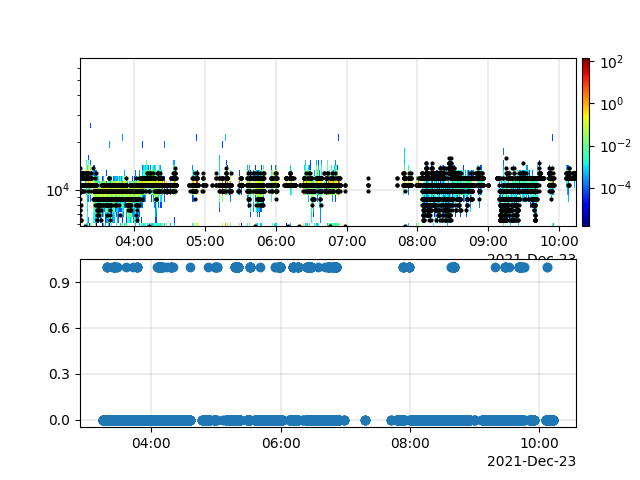

In [ ]:
fig, [ax, ax2] = plt.subplots(2)
plot_line(ax,f_peaks_ts, marker='.', linestyle='', color='black', markersize=4)
ax_s, ax_c = plot_spectr(ax, epsd_data_filt, clim='auto', yscale='log', cscale='log', cmap='jet')

rolling_std = f_peaks_ts.rolling(time=10, center=True).std()
weights_stability = 1 / (rolling_std + 1e-3)  # avoid division by zero

# normalize if you want
weights_stability /= weights_stability.max()

plot_line(ax2, weights_stability, linestyle='', marker='o')

weights_stability.data



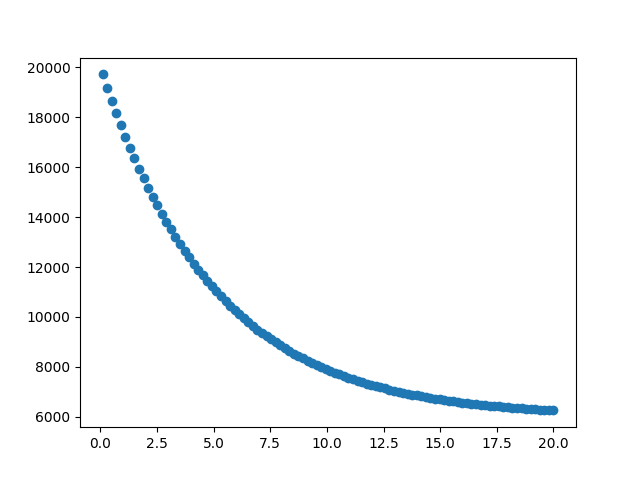

In [ ]:
vmed = np.linspace(0.1, 20, 100)
flow = 6000 + (20000 - 6000) * np.exp(-vmed / 5)
fig, ax = plt.subplots(1)
ax.scatter(vmed, flow)



['2024-05-03T16:25:37.700272500', ' 2024-05-04T08:29:10.000000000']
[['2024-05-03T16:25:37.700272500', ' 2024-05-04T08:29:10.000000000']]
[1]


698

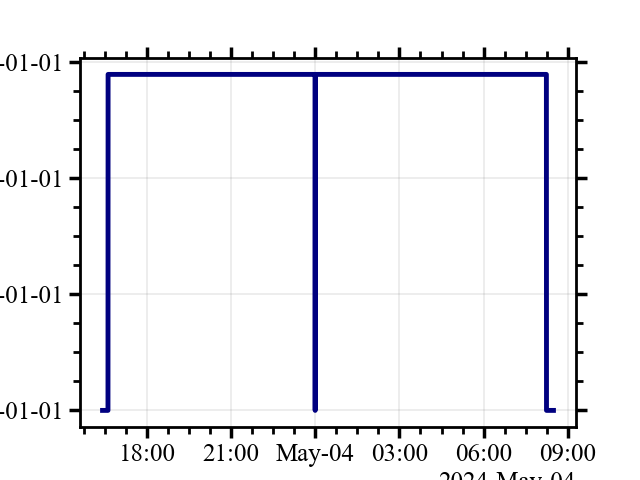

In [ ]:
# tint = ['2024-02-13T22:37:20.000000000','2024-02-14T01:26:50.000000000']
ic = 1
# tint = ['2023-05-16T23:27:35.000000000','2023-05-17T00:06:30.000000000']
vsc = mms.get_data("v_edp_fast_l2", tint, 1).drop_duplicates(dim='time')
tint = ['2024-05-03T16:25:37.700272500',' 2024-05-04T08:29:10.000000000']
ts_axis = np.arange(np.datetime64(tint[0]), np.datetime64(tint[-1]), np.timedelta64(1,'s')).astype('datetime64[ns]')
ts_data = np.ones_like(ts_axis)
ts_mask = pyrf.ts_scalar(ts_axis, ts_data)
print(tint)
from compile_tints import _check_aspoc, _check_vsc, _split_tint, _preprocess_tint
aspoc = mms.get_data('ionc_aspoc_srvy_l2', tint, ic).drop_duplicates(dim='time')
folder = 'sw_tints/'
write_path = folder+'compiled_sw_tints2.csv'
failed_path = folder+'failed_tints2.csv'
tints_p = _preprocess_tint(tint, 0, write_path, failed_path, 1)


print(tints_p)

ts_mask_vsc = _check_vsc(ts_mask, tint, ic)
ts_mask_vsc_aspoc = _check_aspoc(ts_mask_vsc, tint, ic)
a = _split_tint(ts_mask_vsc_aspoc, ic)
print(a)
# diff = ts_mask_aspoc.differentiate(coord='time')
# diff_norm = diff / (np.max(diff) + 1e-6)
plt.close('all')
fig, ax = plt.subplots(1)
# plot_line(ax,aspoc)
# plot_line(ax,ts_mask_vsc_aspoc)

plot_line(ax, ts_mask_vsc)

g = pyrf.resample(vsc, ts_mask.time)#, method='linear')
# plot_line(ax, vsc, marker='.')
# plot_line(ax, g, marker='.')
# plot_line(ax, ts_mask, marker='.')

np.count_nonzero(np.isnan(g))



# Distribution of tint lens

In [ ]:
d
dddd
# Read data from all sc
sw_tints = np.genfromtxt(f'sw_tints/compiled_sw_tints4.csv', dtype=str, skip_header=1, delimiter=',')#, names=True)

# Split into each sc
a

In [ ]:
np.int_(sw_tints[:, 2])

array([1, 1, 1, ..., 4, 4, 4])

Text(0.5, 0.98, 'Distribution of time interval lengths')

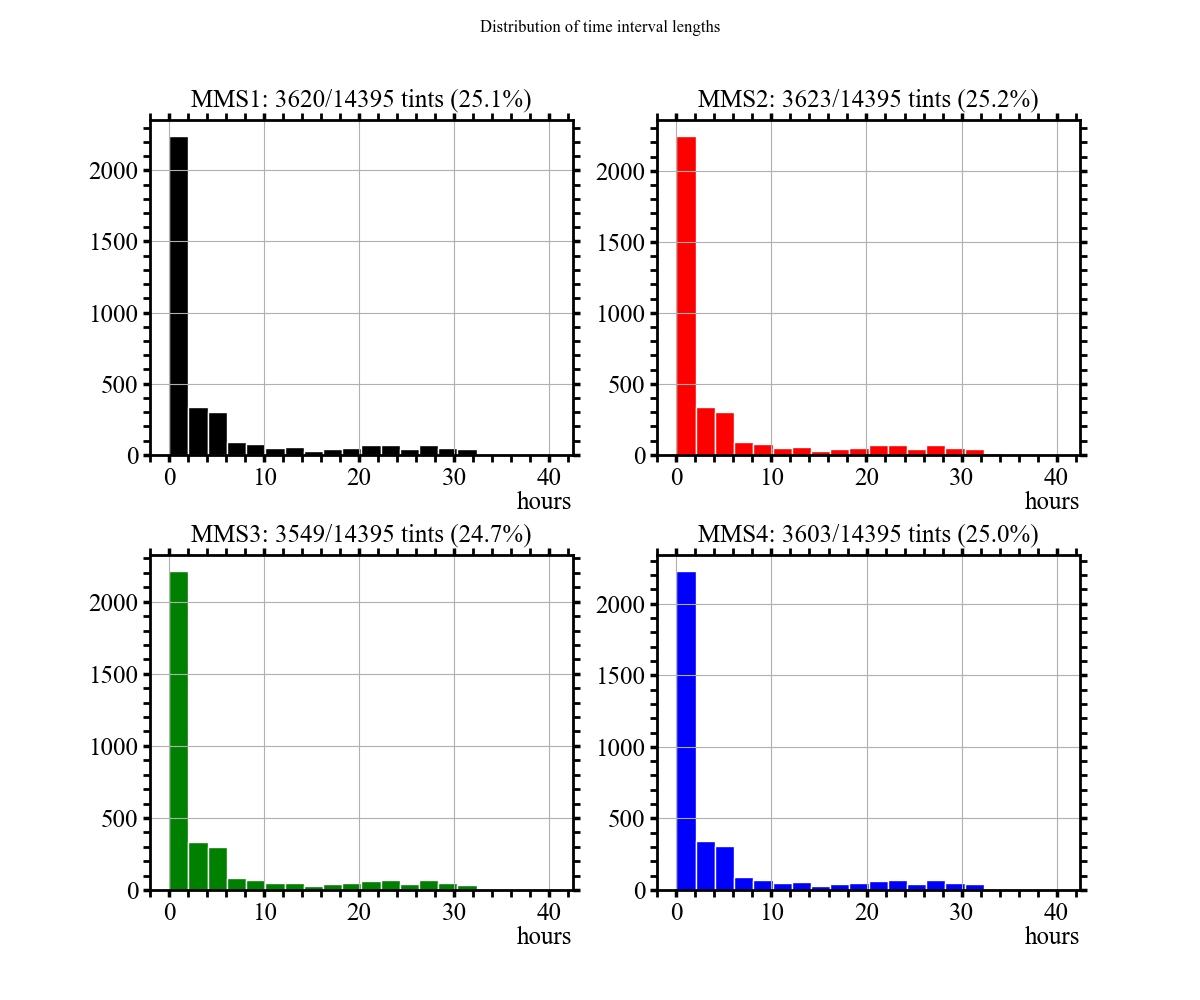

In [ ]:
durations_ic_h = np.empty((4,), dtype=np.ndarray)
colors = ['k','r','g','b']



plt.close('all')
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 10)) 
plt.subplots_adjust(hspace=0.3)
axs_f = axs.flatten()
for ic in [1, 2, 3, 4]:
    sel_idx = (np.int_(sw_tints[:,2]) == ic)
    sw_tints_ic = sw_tints[sel_idx, :2]
    c=0
    durations = []
    for i, tint in enumerate(sw_tints_ic):
        start, end = pyrf.iso86012datetime64(tint)
        duration = (end - start).astype('timedelta64[s]')
        duration_h = duration / np.timedelta64(1, 'h')
        durations.append(duration_h)
        c+=1
    durations = np.array(durations)
    durations_ic_h[ic-1] = durations
    
    ax = axs_f[ic-1]
    hist_vals, bin_eges, _ = ax.hist(durations_ic_h[ic-1], bins=20, edgecolor='white', facecolor=colors[ic-1])
    # ax.set_yscale('log')
    ax.tick_params(which='major', length=5)
    ax.set_xlabel('hours', loc='right')
    ax.set_title(f'MMS{ic}: {c}/{len(sw_tints)} tints ({c/len(sw_tints)*100:.1f}%)')

fig.suptitle(f'Distribution of time interval lengths')


In [10]:
import xarray as xr
import os
import random
from pyrfu import mms
from pyrfu.plot import plot_line
import matplotlib.pyplot as plt
import numpy as np
def get_cdf_filenames(folder: str, mode: str = "all", n: int = 5):
    # Ensure the folder exists
    if not os.path.exists(folder):
        raise FileNotFoundError(f"Folder '{folder}' not found.")
    
    # Look at all subdirectories and collect .cdf file paths
    filenames = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.endswith(".cdf"):
                filenames.append(os.path.join(root, f))

    if mode == "random":
        return random.sample(filenames, 1)
    elif mode == "all":
        return filenames
    else:
        raise ValueError("Invalid mode. Use 'all' or 'random'.")

filenames = get_cdf_filenames('output_data', 'all')
print(len(filenames))
# print(file)
# ne = xr.load_dataarray(file)
# # ne = xr.load_dataarray('output_data/MMS1/2024/05/MMS1_2024-05-03T00-52-25.cdf')
# fig, ax = plt.subplots(1)
# plot_line(ax, ne)

8360


In [ ]:
%reload_ext autoreload
%autoreload 2
from sw_density_from_fpe import sw_density_from_fpe
h = sw_density_from_fpe(['2017-11-30T14:59:37.150837000','2017-11-30T16:22:30.00000000'], 1, 0, write_to='output_data/')

[14-Apr-25 14:17:15] INFO: Loading mms1_edp_scpot_fast_l2...
[14-Apr-25 14:17:15] INFO: Loading mms1_dsp_epsd_omni...


Y


In [15]:
files = get_cdf_filenames('output_data', 'all')
mytint = ['2024-05-03T16:37:16.000000000','2024-05-03T23:59:59.000000000']
# mytint = ['2018-02-29T14:59:37.0000','2017-11-30T16:22:30.00000000']
tint_start = mytint[0]
myic = 1
year = tint_start[:4]
month = tint_start[5:7]
day = tint_start[8:10]
hh = tint_start[11:13]
mm = tint_start[14:16]
ss = tint_start[17:19]

# filename = f'MMS{myic}_{year}-{month}-{day}T{hh}-{mm}-{ss}.cdf'
# filepath = 'output_data/'+f'MMS{myic}'+'/'+year+'/'+month+'/'+filename
# ne_read = xr.load_dataarray(filepath)


start, end = np.datetime64(mytint[0]), np.datetime64(mytint[1])
valid_filenames = []
for f in files:
    datestr = f[:-4].split('_')[-1]
    datestr_fmt = datestr[::-1].replace('-', ':', 2)[::-1]
    tf = np.datetime64(datestr_fmt)
    ic_idx = f.find('MMS')+3
    ic = int(f[ic_idx])
    if start <= tf <= end and ic == myic:
        valid_filenames.append(f)
        print(f, tf, ic)

output_data/MMS1/2024/05/MMS1_2024-05-03T16-37-16.cdf 2024-05-03T16:37:16 1


In [17]:
k = files[321]
datestr = k[:-4].split('_')[-1]
datestr_fmt = datestr[::-1].replace('-', ':', 2)[::-1]
print(datestr_fmt)

2020-03-10T02:42:55


In [ ]:
ne_fit = xr.open_dataarray(valid_filenames[0])
_, beta, N0, ic, tint, sw_mode = ne_fit.attrs.values()
print(tint)
print([ne_fit.time[0].data, ne_fit.time[-1].data])

ValueError: not enough values to unpack (expected 6, got 5)

In [ ]:
from compute_correction_factors import calc_fpi_corr
for vf in valid_filenames:
    calc_fpi_corr(vf, 'output_data/stats/')


TypeError: tint must be a list!!

(0.0, 20.0)

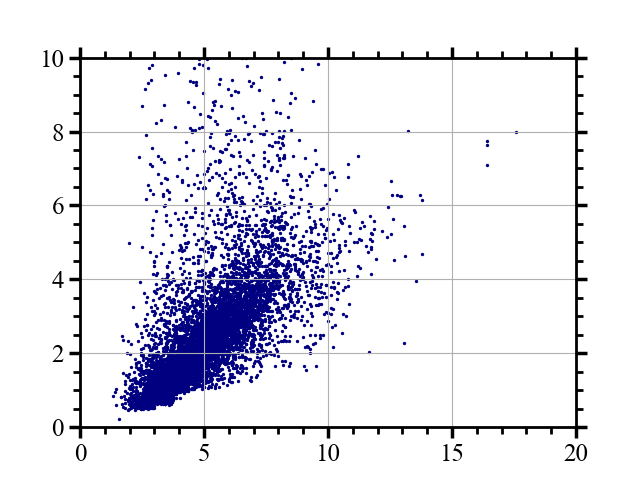

In [13]:
import numpy as np
import matplotlib.pyplot as plt
data_dict = np.genfromtxt('output_data/stats/fitting_stats.csv', delimiter=',', skip_header=0, dtype=None).T

start, end, beta, N0, ic, swmode, vscmed = data_dict[:, 1:]
vscmed=np.float64(vscmed)
beta = np.float64(beta)
fig, ax = plt.subplots(1)
ix = (abs(beta) < 20) & (abs(vscmed < 100))
ax.scatter(vscmed[ix], beta[ix], s=2)

ax.set_ylim(0, 10)
ax.set_xlim(0, 20)





In [14]:
import numpy as np
import matplotlib.pyplot as plt 
data = np.genfromtxt('output_data/stats/density_correction_stats.csv', delimiter=',', dtype=None, skip_header=0, names=True)

# Convert to dictionary for easy unpacking
data_dict = {name: data[name] for name in data.dtype.names}

# Unpack values

start_str, stop_str, c0, vsc_mean, t_e_mean, beta, N0, ic = data_dict.values()

(array([4.200e+01, 3.000e+00, 1.000e+00, 2.000e+00, 8.000e+00, 1.100e+01,
        5.000e+00, 3.000e+00, 6.000e+00, 3.400e+01, 5.800e+01, 1.310e+02,
        4.290e+02, 1.603e+03, 4.680e+03, 7.975e+03, 9.272e+03, 9.918e+03,
        9.076e+03, 6.678e+03, 4.415e+03, 3.004e+03, 1.892e+03, 1.102e+03,
        7.720e+02, 5.400e+02, 3.900e+02, 2.800e+02, 2.500e+02, 1.820e+02,
        1.860e+02, 1.450e+02, 9.800e+01, 8.700e+01, 7.200e+01, 7.500e+01,
        7.000e+01, 3.200e+01, 3.200e+01, 3.300e+01]),
 array([1.58427491e-06, 7.49880056e-02, 1.49974427e-01, 2.24960848e-01,
        2.99947270e-01, 3.74933691e-01, 4.49920112e-01, 5.24906534e-01,
        5.99892955e-01, 6.74879376e-01, 7.49865798e-01, 8.24852219e-01,
        8.99838640e-01, 9.74825062e-01, 1.04981148e+00, 1.12479790e+00,
        1.19978433e+00, 1.27477075e+00, 1.34975717e+00, 1.42474359e+00,
        1.49973001e+00, 1.57471643e+00, 1.64970285e+00, 1.72468927e+00,
        1.79967570e+00, 1.87466212e+00, 1.94964854e+00, 2.02463496e+00

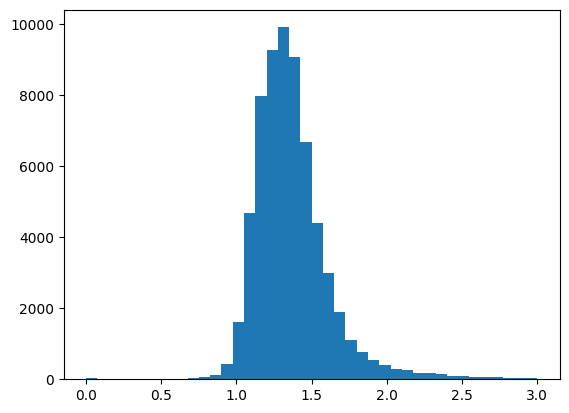

In [20]:
fig, ax = plt.subplots(1)
ax.hist(c0[abs(c0) < 3], bins=40)